In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Pregunta No. 1:
Análisis de ventas por categoría de artículo: ¿Cuáles son las categorías de artículo más vendidas? ¿Cómo varía el total de ventas entre estas categorías? ¿Hay alguna categoría que destaque por encima de las demás en términos de ingresos?

#### Primero se importa la tabla de ventas


In [5]:
data_resp1 = pd.read_csv('dimDetalleVenta.csv')
data_resp1

,iddetalle_venta,cantidad,precio,descuento,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,idcategoria,codigo,nombre,precio_venta,stock,descripcion,imagen,estado_articulo
0,4096006,65,573.12,357.44,Ticket de Venta,7805814,56113962,2023-04-07,52.59,37535.91,Reembolsada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
1,7549374,43,573.12,114.24,Ticket de Venta,3302553,88423546,2018-02-22,21.09,28862.28,En proceso,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
2,5146385,27,573.12,683.13,Recibo,3827757,97994785,2016-10-11,92.32,55265.83,Completada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
3,5947354,26,573.12,825.77,Ticket de Venta,8606440,34222761,2020-12-13,55.19,20974.22,Reembolsada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
4,3973137,87,573.12,789.20,Nota de Débito,9532676,66856154,2015-11-17,70.69,61993.96,Cancelada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6255404,24,641.86,704.27,Recibo,3777339,99185410,2020-03-31,94.11,57554.64,Reembolsada,51470,htJDIcNk,Juguete Officer,641.86,74,Artículo Juguete Officer en venta en tienda,fig_130,1
4996,8370819,38,823.77,726.39,Boleta de Venta,7872997,19906961,2018-03-30,99.00,33569.60,En proceso,75369,M9xq0QgN,Teléfono Available,823.77,2,Artículo Teléfono Available en venta en tienda,fig_353,1
4997,5683501,72,911.30,749.01,Ticket de Venta,5171797,70806013,2018-07-07,73.70,39597.27,Pendiente,82016,pTy8a2xc,Tenis Beat,911.30,2,Artículo Tenis Beat en venta en tienda,fig_412,1
4998,6211525,43,865.75,235.92,Ticket de Venta,7965513,42928907,2023-11-12,2.88,94129.24,Cancelada,40879,ithGlQe0,Maquillaje Fight,865.75,78,Artículo Maquillaje Fight en venta en tienda,fig_314,1


In [6]:
data_resp1.columns

Index(['iddetalle_venta', 'cantidad', 'precio', 'descuento',
       'tipo_comprobante', 'serie_comprobante', 'num_comprobante', 'fecha',
       'impuesto', 'total', 'estado_venta', 'idcategoria', 'codigo', 'nombre',
       'precio_venta', 'stock', 'descripcion', 'imagen', 'estado_articulo'],
      dtype='object')

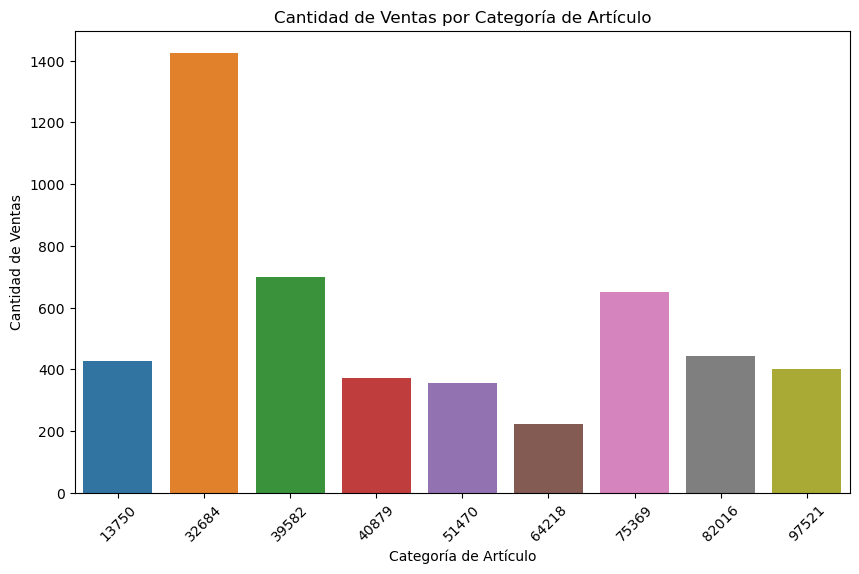

In [8]:
# Crear el gráfico usando Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data_resp1, x='idcategoria')
plt.title('Cantidad de Ventas por Categoría de Artículo')
plt.xlabel('Categoría de Artículo')
plt.ylabel('Cantidad de Ventas')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()